In [293]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


## Load data in ##

In [191]:
#June 2019 MTA data
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt')
june_data_raw = pd.concat([df1,df2,df3,df4], ignore_index = True)

In [317]:
#Zip codes of MTA stations
zip_codes = pd.read_csv('https://raw.githubusercontent.com/galenballew/Metis-Submissions/master/projects/01%20Benson/data/processed/zips.csv')
zip_codes['zip_code']=zip_codes['zip_code'].astype('str')

In [319]:
#Load in and clean income data by zip code
income_data = pd.read_csv('NY_Income_by_Zipcode.csv')
income_data = income_data.filter(['Geographic Area Name', 'Estimate!!Households!!Median income (dollars)'])
income_data.rename(columns={'Geographic Area Name' : 'zipcode','Estimate!!Households!!Median income (dollars)': 'Median income'}, inplace = True)
income_data['zipcode']=income_data['zipcode'].str.replace(r'ZCTA5 ', '')
#Fill blank values with median NYC income
income_data[income_data['zipcode']=='10020'] = '57782'
income_data[income_data['zipcode']=='10119'] = '57782'

In [320]:
#Join zip code and income data
zip_codes=zip_codes.set_index('zip_code').join(income_data.set_index('zipcode'))\
                   .reset_index().drop_duplicates(subset=['station'])
zip_codes.rename(columns = {'index': 'zipcode', 'Median income': 'zip income'},inplace=True)
zip_codes['zip income']=zip_codes['zip income'].astype('float')
zip_codes.fillna(57782, inplace=True)
zip_codes

,zipcode,station,zip income
0,10001,28 ST,92840.0
2,10001,THIRTY ST,92840.0
4,10001,THIRTY THIRD ST,92840.0
6,10001,33 ST,92840.0
8,10001,34 ST-HUDSON YD,92840.0
...,...,...,...
722,7114,NEWARK C,57782.0
723,7302,GROVE STREET,57782.0
724,7302,EXCHANGE PLACE,57782.0
725,7306,JOURNAL SQUARE,57782.0


## Cleaning turnstile data: ##

Fix column names by clarifying entries and exits are cumulative, add a combined datetime column, get rid of times that aren't on the hour (these seem to have weird results that throw the others off)

In [226]:
june_data_raw.rename(columns={'EXITS                                                               ':"CU_EXITS", \
                          'ENTRIES': 'CU_ENTRIES'}, inplace=True)
june_data_raw['DATETIME'] = pd.to_datetime(june_data_raw['DATE'] + ' ' + june_data_raw['TIME'])
june_data_raw = june_data_raw[(june_data_raw['DATETIME'].dt.minute==0)&(june_data_raw['DATETIME'].dt.second==0)].copy()

## Processing ##

In [227]:
#Group the turnstile data together by datetime, not sure if this is necessary since each turnstile at each time 
#only appears once, may be able to get rid of this
june_data = (june_data_raw.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", 'TIME'],as_index=False)
            [['CU_ENTRIES','CU_EXITS']].last())

In [228]:
#Add columns for entries since the last timestep for each turnstile
june_data[['ENTRIES','EXITS']] = (june_data
                                          .groupby(["C/A", "UNIT", "SCP", "STATION"])[[ "CU_ENTRIES", 'CU_EXITS']]
                                          .apply(lambda x: x.subtract(x.shift(1))))
june_data.dropna(inplace=True)

In [229]:
#Add up turnstiles to get entries and exits for station during the specified time interval (4 hours before timestamp)
june_data = june_data.groupby(['STATION', 'DATE', 'TIME'])[['ENTRIES', 'EXITS']].sum().reset_index()

In [230]:
#More cleaning, get rid of bad values: negative or too high, 1 million people shouldnt pass through station
#in 4 hours
mask = ((june_data['ENTRIES'] >= 0) & \
        (june_data['EXITS'] >= 0) & \
        (june_data['ENTRIES'] < 1e6) & \
        (june_data['EXITS'] < 1e6))
june_data = june_data[mask].copy()

In [231]:
#Make total ridership column
june_data['TOTAL RIDERSHIP'] = june_data['ENTRIES']+june_data['EXITS']

In [232]:
june_data['DAYOFWEEK'] = pd.to_datetime(june_data['DATE']).dt.dayofweek

In [233]:
june_data = june_data.set_index('STATION').join(zip_codes.set_index('station')).reset_index()
june_data.rename(columns = {'index': 'STATION'},inplace=True)
june_data

,STATION,DATE,TIME,ENTRIES,EXITS,TOTAL RIDERSHIP,DAYOFWEEK,zipcode,zip income
0,1 AV,06/01/2019,04:00:00,643.0,627.0,1270.0,5,10009,63717.0
1,1 AV,06/01/2019,08:00:00,182.0,609.0,791.0,5,10009,63717.0
2,1 AV,06/01/2019,12:00:00,776.0,1697.0,2473.0,5,10009,63717.0
3,1 AV,06/01/2019,16:00:00,1933.0,2325.0,4258.0,5,10009,63717.0
4,1 AV,06/01/2019,20:00:00,1883.0,2443.0,4326.0,5,10009,63717.0
...,...,...,...,...,...,...,...,...,...
65693,ZEREGA AV,06/28/2019,05:00:00,66.0,103.0,169.0,4,10462,54278.0
65694,ZEREGA AV,06/28/2019,09:00:00,894.0,408.0,1302.0,4,10462,54278.0
65695,ZEREGA AV,06/28/2019,13:00:00,520.0,292.0,812.0,4,10462,54278.0
65696,ZEREGA AV,06/28/2019,17:00:00,611.0,543.0,1154.0,4,10462,54278.0


In [206]:
june_data.groupby(['STATION', 'DATE'])['TIME'].count().sort_values(ascending=False)

STATION          DATE      
FULTON ST        06/27/2019    18
                 06/14/2019    18
                 06/03/2019    18
                 06/04/2019    18
                 06/05/2019    18
                               ..
6 AV             06/05/2019     2
191 ST           06/13/2019     2
190 ST           06/09/2019     2
AVENUE I         06/09/2019     1
THIRTY THIRD ST  06/03/2019     1
Name: TIME, Length: 9960, dtype: int64

## From here we can split off the data into various forms that we want to look at ##

**Daily ridership data for each station**

In [234]:
june_data_daily = june_data.groupby(['STATION', 'DATE','DAYOFWEEK'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [235]:
june_data_daily

,STATION,DATE,DAYOFWEEK,TOTAL RIDERSHIP
0,1 AV,06/01/2019,5,13118.0
1,1 AV,06/02/2019,6,13207.0
2,1 AV,06/03/2019,0,35980.0
3,1 AV,06/04/2019,1,36109.0
4,1 AV,06/05/2019,2,40614.0
...,...,...,...,...
9955,ZEREGA AV,06/24/2019,0,5236.0
9956,ZEREGA AV,06/25/2019,1,5128.0
9957,ZEREGA AV,06/26/2019,2,5590.0
9958,ZEREGA AV,06/27/2019,3,5203.0


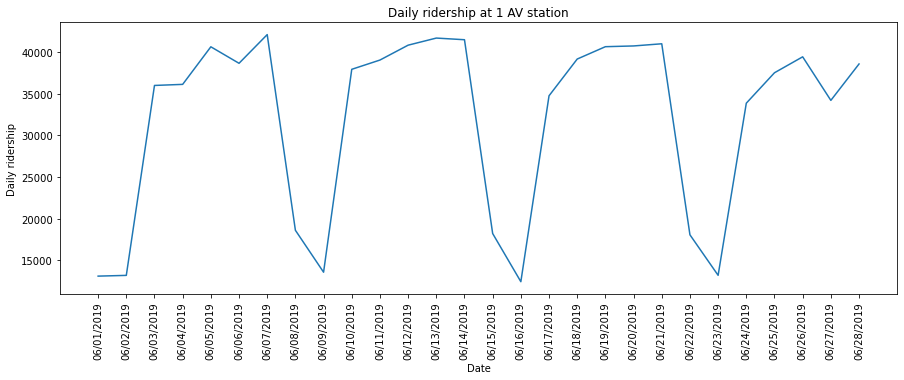

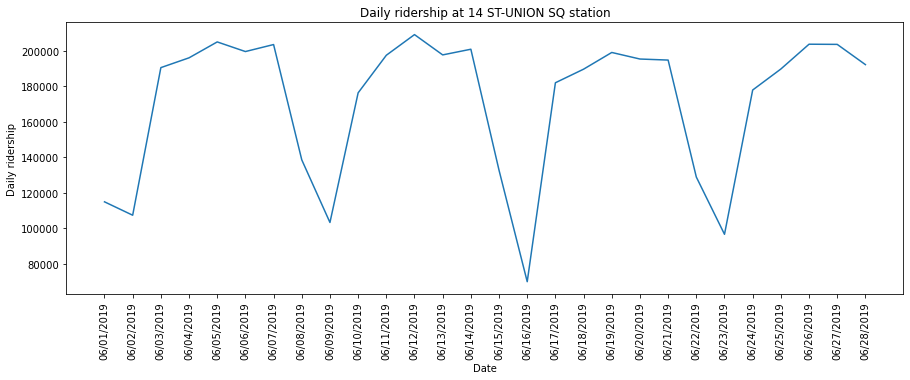

In [59]:
#Function for plotting monthly time series of stop
def plot_monthly_series(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    plt.figure(figsize = (15,5))
    plt.plot(station_df['DATE'], station_df['TOTAL RIDERSHIP'])
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Date')
    plt.ylabel('Daily ridership')
    plt.title('Daily ridership at ' + station + ' station')
    plt.show()
plot_monthly_series(june_data_daily, '1 AV')
plot_monthly_series(june_data_daily, '14 ST-UNION SQ')

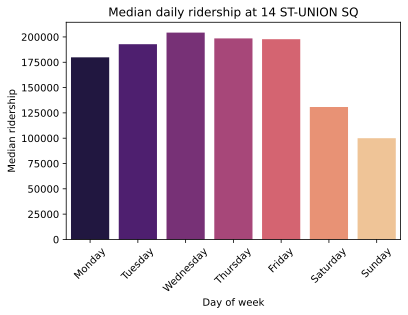

In [321]:
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#Function for plotting median ridership at a station 
def plot_weekly(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    median_ridership = station_df.groupby(['DAYOFWEEK'])['TOTAL RIDERSHIP'].median()
    #plt.plot(days, median_ridership, 'bo')
    #plt.xticks(rotation = 'vertical')
    #plt.xlabel('Day of week')
    #plt.ylabel('Median ridership on day')
    #plt.title('Median daily ridership per weekday at ' + station + ' station')
    #plt.show()
    ax=sns.barplot(x = days, y = median_ridership, palette = 'magma')
    ax.set(xlabel = 'Day of week', ylabel = 'Median ridership', title = 'Median daily ridership at '+ station)
    plt.xticks(rotation = 45)
plot_weekly(june_data_daily, '14 ST-UNION SQ')

## Hourly data ##

In [61]:
june_data_hourly = june_data.groupby(['STATION', 'TIME','DAYOFWEEK'])[['TOTAL RIDERSHIP']].sum().reset_index()

In [62]:
june_data_hourly

,STATION,TIME,DAYOFWEEK,TOTAL RIDERSHIP
0,1 AV,00:00:00,0,8747.0
1,1 AV,00:00:00,1,15663.0
2,1 AV,00:00:00,2,19041.0
3,1 AV,00:00:00,3,19659.0
4,1 AV,00:00:00,4,20631.0
...,...,...,...,...
16587,ZEREGA AV,21:00:00,2,4764.0
16588,ZEREGA AV,21:00:00,3,4548.0
16589,ZEREGA AV,21:00:00,4,4345.0
16590,ZEREGA AV,21:00:00,5,2303.0


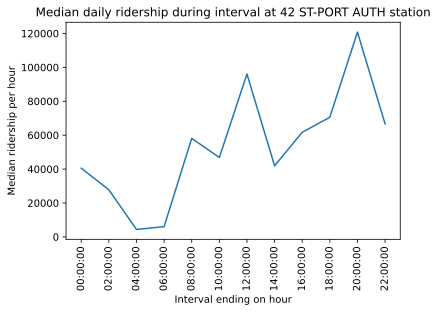

In [322]:
#Plot median 4-hourly traffic at station
def plot_hourly(df, station, weekday_only = True):
    station_df = df.loc[df['STATION'] == station].copy()
    if weekday_only:
        station_df = station_df[station_df['DAYOFWEEK']<=4] #0-4 = monday to friday
    median_ridership = station_df.groupby(['TIME'])['TOTAL RIDERSHIP'].median()
    plt.plot(median_ridership.index, median_ridership)
    plt.xticks(rotation='vertical')
    plt.xlabel('Interval ending on hour')
    plt.ylabel('Median ridership per hour')
    plt.title('Median daily ridership during interval at ' + station + ' station')
    plt.show()

plot_hourly(june_data_hourly, '42 ST-PORT AUTH')

**Summary statistics for ridership across the whole month, indexed by station**

In [323]:
june_data_station_stats = june_data.groupby(['STATION','zip income'])['TOTAL RIDERSHIP']\
                            .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                            .reset_index().sort_values('MEDIAN', ascending = False)
weekday_mask = june_data['DAYOFWEEK'] <= 4
june_data_station_weekday_stats = june_data[weekday_mask].groupby(['STATION','zip income'])['TOTAL RIDERSHIP']\
                                 .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                                 .reset_index().sort_values('MEDIAN', ascending = False)

In [338]:
top_income_stations = june_data_station_stats.sort_values('zip income', ascending = False)['STATION']
top_median_stations = june_data_station_stats.sort_values('MEDIAN', ascending = False)['STATION']
top_sum_stations    = june_data_station_stats.sort_values('SUM', ascending = False)['STATION']
top_median_stations_wd = june_data_station_weekday_stats.sort_values('MEDIAN', ascending = False)['STATION']
top_sum_stations_wd    = june_data_station_weekday_stats.sort_values('SUM', ascending = False)['STATION']

In [351]:
def plot_ridership_bar(stats_df, station_list, metric, title, show_income = False):
    stations_df = stats_df[stats_df['STATION'].isin(station_list)][['STATION','zip income',metric]]
    stations_df.sort_values(metric, ascending = False, inplace=True)
    stations = stations_df['STATION']
    station_metrics = stations_df[metric]
    station_incomes = stations_df['zip income']
    
    if show_income:
        plt.figure(figsize=(15,6))

        norm = plt.Normalize(station_incomes.min(), station_incomes.max())
        sm = plt.cm.ScalarMappable(cmap="magma", norm=norm) #or magma
        sm.set_array([])
        
        ax = sns.barplot(x=stations, y=station_metrics, hue=station_incomes, palette='magma', dodge=False)
        
        ax.set_ylabel('Ridership')
        ax.set_xlabel('Station')
        ax.get_legend().remove()
        cb=ax.figure.colorbar(sm)
        cb.set_label('Median income of station zipcode ($)')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()
    else:
        plt.figure(figsize=(12,6))

        ax = sns.barplot(x=stations, y=station_metrics, color='DarkSlateBlue', dodge=False)
        
        ax.set_ylabel('Ridership')
        ax.set_xlabel('Station')
        plt.xticks(rotation=90)
        plt.title(title)
        plt.show()

def plot_income_bar(stats_df, station_list, title):
    stations_df = stats_df[stats_df['STATION'].isin(station_list)][['STATION','zip income']]
    stations_df.sort_values('zip income', ascending = False, inplace=True)
    stations = stations_df['STATION']
    station_incomes = stations_df['zip income']
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=stations, y = station_incomes, palette = 'magma', dodge = False)
    plt.xlabel('Station')
    plt.xticks(rotation=90)
    plt.ylabel('Median income of station zipcode ($)')
    plt.title(title)
    plt.show()

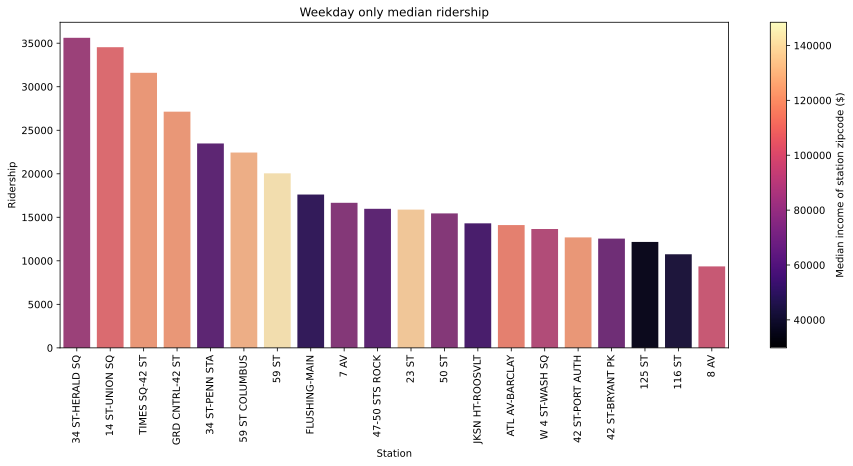

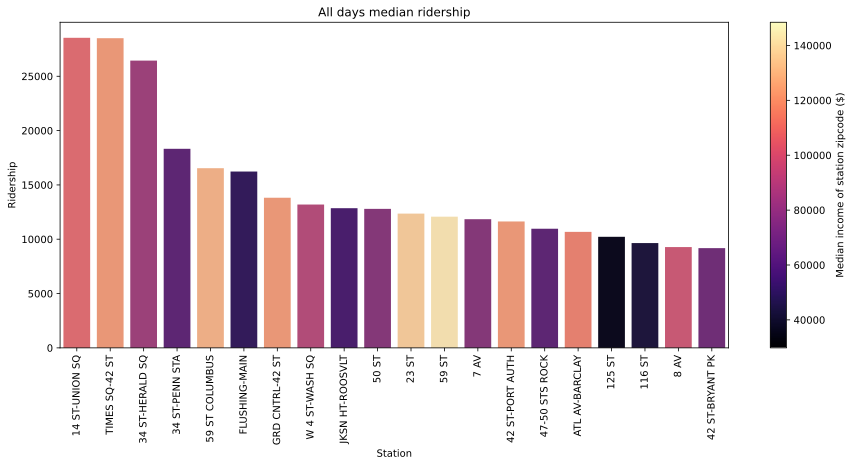

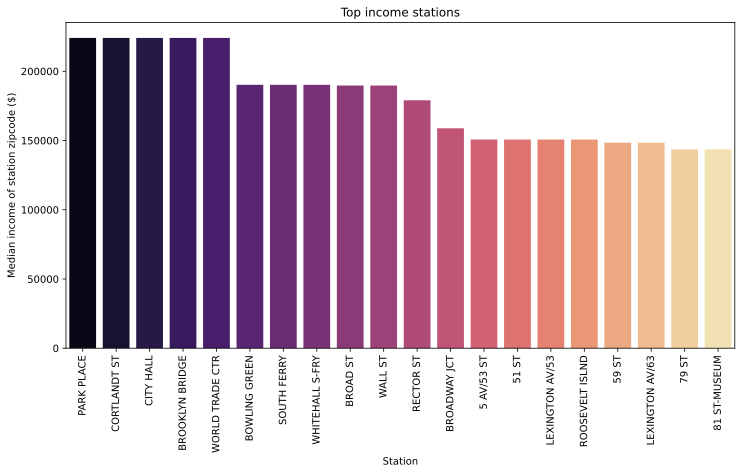

In [353]:
plot_ridership_bar(june_data_station_weekday_stats, top_median_stations[:20], 'MEDIAN', 'Weekday only median ridership', show_income = True)
plot_ridership_bar(june_data_station_stats, top_median_stations[:20], 'MEDIAN', 'All days median ridership', show_income = True)
plot_income_bar(june_data_station_stats, top_income_stations[:20], 'Top income stations')
